c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.5533 - loss: 0.7063 - val_accuracy: 0.4293 - val_loss: 0.8537 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5491 - loss: 0.6915 - val_accuracy: 0.5367 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5404 - loss: 0.6928 - val_accuracy: 0.5707 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.5720 - loss: 0.6893 - val_accuracy: 0.5707 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5998 - loss: 0.6745 - val_accuracy: 0.5707 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.5410 - loss: 0.6828 - val_accuracy: 0.5707 - val_loss: 0.6808 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5568 - loss: 0.6800 - val_accuracy:

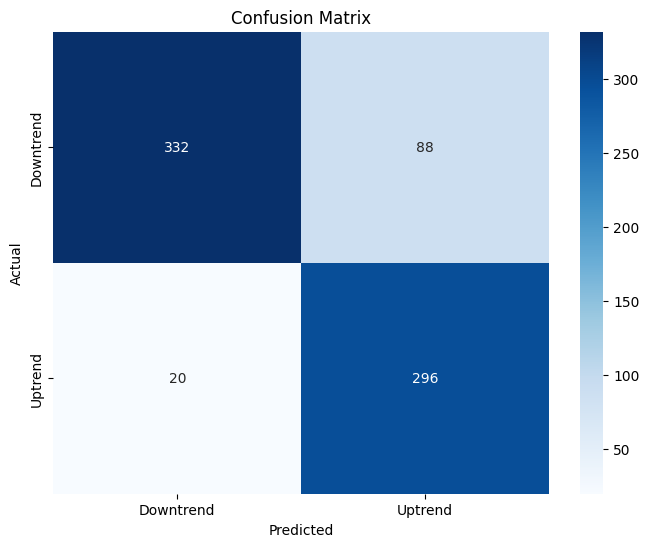

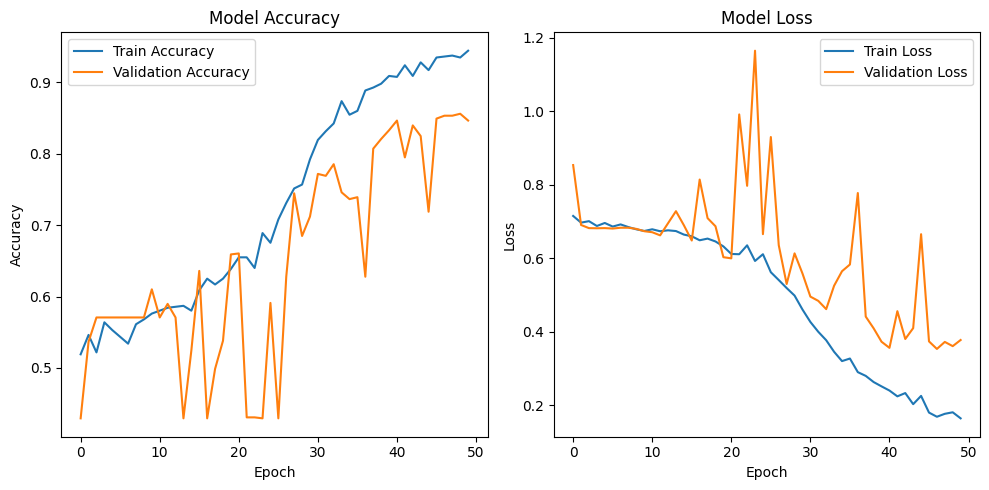


Exemples de prédictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


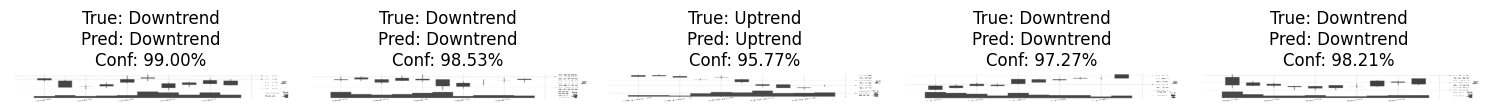

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

# 1. Data Preparation -------------------------------------------------

def split_image(img, days=10):
    """Split a combined image into 10 sub-images (1 per day)"""
    height, width = img.shape[:2]
    day_width = width // days
    day_images = []
    
    for i in range(days):
        start_x = i * day_width
        day_img = img[:, start_x:start_x+day_width]
        day_images.append(day_img)
    
    return np.array(day_images)

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir='dataset-30', batch_size=32, img_size=(64,64), shuffle=True, test_size=0.2, validation_split=0.2):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.test_size = test_size
        self.validation_split = validation_split
        
        # Initialize all paths and labels
        self.image_paths = []
        self.labels = []
        self.train_paths = []
        self.train_labels = []
        self.val_paths = []
        self.val_labels = []
        self.test_paths = []
        self.test_labels = []
        self.current_paths = []
        self.current_labels = []
        
        # Get all image paths and labels
        for label, trend in enumerate(['uptrend', 'downtrend']):
            trend_dir = os.path.join(data_dir, trend)
            for img_file in os.listdir(trend_dir):
                self.image_paths.append(os.path.join(trend_dir, img_file))
                self.labels.append(label)
        
        # Split into train/val/test
        self.train_paths, self.test_paths, self.train_labels, self.test_labels = train_test_split(
            self.image_paths, self.labels, test_size=test_size, random_state=42)
        self.train_paths, self.val_paths, self.train_labels, self.val_labels = train_test_split(
            self.train_paths, self.train_labels, test_size=validation_split, random_state=42)
        
        # Set initial mode
        self.mode = 'train'
        self.current_paths = self.train_paths
        self.current_labels = self.train_labels
        
        self.on_epoch_end()
    
    def set_mode(self, mode):
        """Set the generator mode: 'train', 'val', or 'test'"""
        self.mode = mode
        if mode == 'train':
            self.current_paths = self.train_paths
            self.current_labels = self.train_labels
        elif mode == 'val':
            self.current_paths = self.val_paths
            self.current_labels = self.val_labels
        elif mode == 'test':
            self.current_paths = self.test_paths
            self.current_labels = self.test_labels
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.current_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.current_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.current_labels[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.empty((self.batch_size, 10, *self.img_size, 1))
        y = np.empty((self.batch_size), dtype=int)
        
        for i, (path, label) in enumerate(zip(batch_paths, batch_labels)):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            sequence = split_image(img)
            
            for j, day_img in enumerate(sequence):
                day_img = cv2.resize(day_img, self.img_size)
                X[i,j,...,0] = day_img / 255.0
            
            y[i] = label
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle and self.mode == 'train':
            combined = list(zip(self.current_paths, self.current_labels))
            random.shuffle(combined)
            self.current_paths, self.current_labels = zip(*combined)
# 2. Model Architecture --------------------------------------------------

def create_model(input_shape=(10, 64, 64, 1)):
    model = Sequential()
    
    # CNN to process each image
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Flatten()))
    
    # LSTM to analyze the time sequence
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# 3. Training and Evaluation ---------------------------------------------

def train_model_with_generator(train_gen, val_gen):
    callbacks = [
        EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    ]
    
    model = create_model()
    
    history = model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=callbacks
    )
    
    return model, history

def evaluate_model_with_generator(model, test_gen):
    # 1. Calcul des prédictions
    y_pred = model.predict(test_gen)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # 2. Récupération des vrais labels et des images de test
    y_true = []
    test_images = []
    test_sequences = []
    
    for i in range(len(test_gen)):
        X_batch, y_batch = test_gen[i]
        y_true.extend(y_batch)
        if i == 0:  # On garde le premier batch pour visualisation
            test_images = X_batch
            test_sequences = [np.concatenate([frame for frame in seq], axis=1) for seq in X_batch]  # Concaténation des 10 jours
    
    y_true = np.array(y_true)
    
    # 3. Calcul et affichage de l'accuracy
    test_accuracy = np.mean(y_true == y_pred_classes[:len(y_true)])
    print(f"\nTest Accuracy: {test_accuracy:.2%}\n")
    
    # 4. Rapport de classification
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes[:len(y_true)]))
    
    # 5. Matrice de confusion
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred_classes[:len(y_true)])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Downtrend', 'Uptrend'],
                yticklabels=['Downtrend', 'Uptrend'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # 6. Courbes d'apprentissage
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 7. Affichage d'exemples avec prédictions
    print("\nExemples de prédictions:")
    sample_preds = model.predict(test_images[:5])  # Prendre 5 exemples
    
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        # Afficher la séquence complète des 10 jours concaténés
        plt.imshow(test_sequences[i], cmap='gray')
        pred_label = 'Uptrend' if sample_preds[i] > 0.5 else 'Downtrend'
        confidence = max(sample_preds[i][0], 1 - sample_preds[i][0])
        true_label = 'Uptrend' if y_true[i] == 1 else 'Downtrend'
        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# 4. Main Execution ---------------------------------------------------

if __name__ == "__main__":
    # Create a single generator and set modes
    data_gen = DataGenerator('dataset', img_size=(64, 64), batch_size=32)
    
    # Set modes for each dataset
    data_gen.set_mode('train')
    train_gen = data_gen
    
    data_gen.set_mode('val')
    val_gen = data_gen
    
    data_gen.set_mode('test')
    test_gen = data_gen
    
    # Train model
    model, history = train_model_with_generator(train_gen, val_gen)
    
    # Evaluate
    evaluate_model_with_generator(model, test_gen)
    
    # Save model
    model.save('trading_trend_model.h5')